### Imports

In [237]:
import functools as ft
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from bagpy import bagreader
from pathlib import Path
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

from utils import plot_signal, unpack_servo_data, unpack_ang_vel_data, calculate_mean_power

### Constants

In [238]:
DATA_DIR = Path('../data/train_set/csv/')
OLD = False

# Sinlge run

### Directories

In [240]:
# bag_dir = '../data/train_set/fixed/1_Panele/4W/R1/45deg/T1/2023-01-05-18-09-29'
# bag_dir = '../data/train_set/fixed/1_Panele/6W/R1/45deg/circlesT1/panels_1_2023-07-17-14-25-00'
# bag_dir = '../data/train_set/fixed/2_Wykladzina_czarna/4W/R1/45deg/T1/2023-01-10-16-43-04'
# bag_dir = '../data/train_set/fixed/2_Wykladzina_czarna/6W/R1/45deg/circlesT1/blackCarpet_1_2023-07-17-11-31-44'
# bag_dir = '../data/train_set/fixed/3_Wykladzina_jasna/4W/R1/45deg/T1/2023-01-12-13-33-06'
# bag_dir = '../data/train_set/fixed/3_Wykladzina_jasna/6W/R1/45deg/circlesT1/brightCarpet_1_2023-07-17-11-01-46'
# bag_dir = '../data/train_set/fixed/4_Trawa/4W/R1/45deg/T1/2023-01-14-12-38-55'
# bag_dir = '../data/train_set/fixed/4_Trawa/6W/R1/45deg/circlesT1/grass_1_2023-07-17-13-04-50'
# bag_dir = '../data/train_set/fixed/5_Spienione_PCV/4W/R1/45deg/T1/2023-01-14-15-03-48'
# bag_dir = '../data/train_set/fixed/5_Spienione_PCV/6W/R1/45deg/circlesT1/QR_1_2023-07-17-12-31-24'
# bag_dir = '../data/train_set/fixed/6_Linoleum/4W/R1/45deg/T1/2023-01-14-16-00-17'
# bag_dir = '../data/train_set/fixed/6_Linoleum/6W/R1/45deg/circlesT1/Linoleum_1_2023-07-17-10-22-55'
# bag_dir = '../data/train_set/fixed/7_Plytki_w_sali/4W/R1/45deg/T1/2023-01-15-15-47-30'
# bag_dir = '../data/train_set/fixed/7_Plytki_w_sali/6W/R1/45deg/circlesT1/tiles_1_2023-07-13-16-48-17'
# bag_dir = '../data/train_set/fixed/8_Pusta_plyta/4W/R1/45deg/T1/2023-01-15-13-23-37'
# bag_dir = '../data/train_set/fixed/8_Pusta_plyta/6W/R1/45deg/circlesT1/OSB_1_2023-07-17-12-00-56'
# bag_dir = '../data/train_set/fixed/9_podklady/4W/R1/45deg/T1/2023-01-15-14-12-52'
# bag_dir = '../data/train_set/fixed/9_podklady/6W/R1/45deg/circlesT1/gray_1_2023-07-13-18-06-16'
# bag_dir = '../data/train_set/fixed/10_Mata_ukladana/4W/R1/45deg/T1/2023-01-15-16-41-51'
bag_dir = '../data/train_set/fixed/10_Mata_ukladana/6W/R1/45deg/circlesT1/blueFoam_1_2023-07-14-08-30-27'

if '4W' in bag_dir:
    OLD = True

### Load data from csv

In [241]:
bag_file_path = bag_dir + '.bag'
b = bagreader(bag_file_path)

[INFO]  Data folder ../data/train_set/fixed/10_Mata_ukladana/6W/R1/45deg/circlesT1/blueFoam_1_2023-07-14-08-30-27 already exists. Not creating.


In [242]:
b.topic_table

,Topics,Types,Message Count,Frequency
0,/Servo_data,universal_robot_msg/Measurements,951,31.189054
1,/begin_write,std_msgs/String,1,NaN
2,/cmd_vel,geometry_msgs/TwistStamped,1043,36.285418
3,/diagnostics,diagnostic_msgs/DiagnosticArray,32,0.992142
4,/filter/quaternion,geometry_msgs/QuaternionStamped,3074,316.193291
5,/imu/acceleration,geometry_msgs/Vector3Stamped,3074,315.218999
6,/imu/angular_velocity,geometry_msgs/Vector3Stamped,3074,317.317597
7,/imu/data,sensor_msgs/Imu,3074,316.264817
8,/imu/mag,geometry_msgs/Vector3Stamped,3074,345.950511
9,/imu/time_ref,sensor_msgs/TimeReference,3063,352.521768


In [243]:
topic_data = {file[:-4]: pd.read_csv(os.path.join(bag_dir, file)) for file in os.listdir(bag_dir)}

### Topics visualization

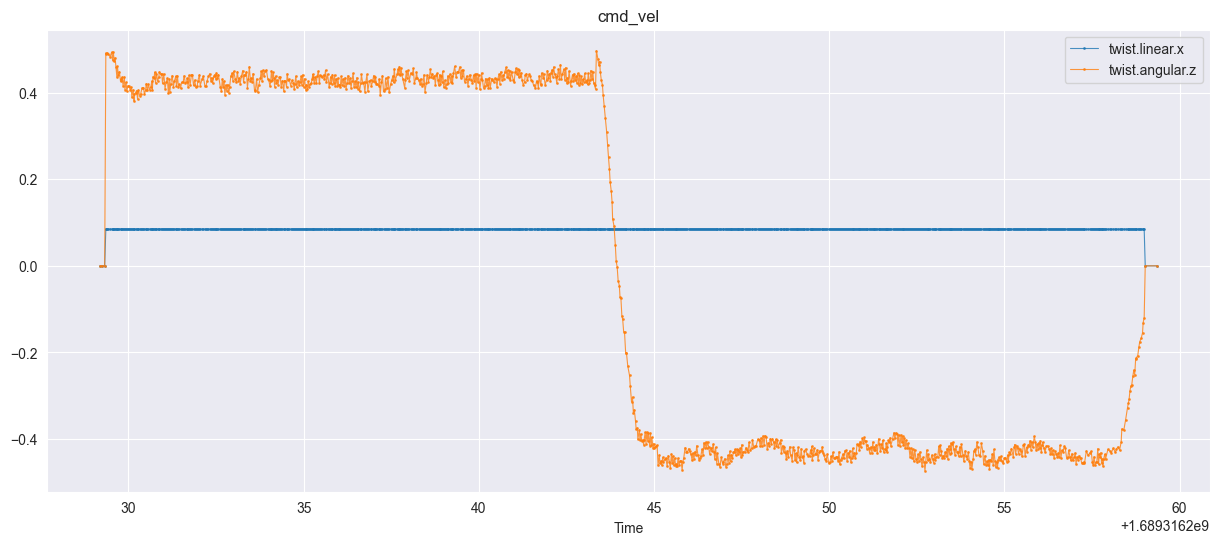

In [244]:
key = 'cmd_vel'
cmd_vel = topic_data[key]
if '4W' in bag_dir:
    cols = ['linear.x', 'angular.z']
else:
    cols = ['twist.linear.x', 'twist.angular.z']
plot_signal(cmd_vel, cols, key)

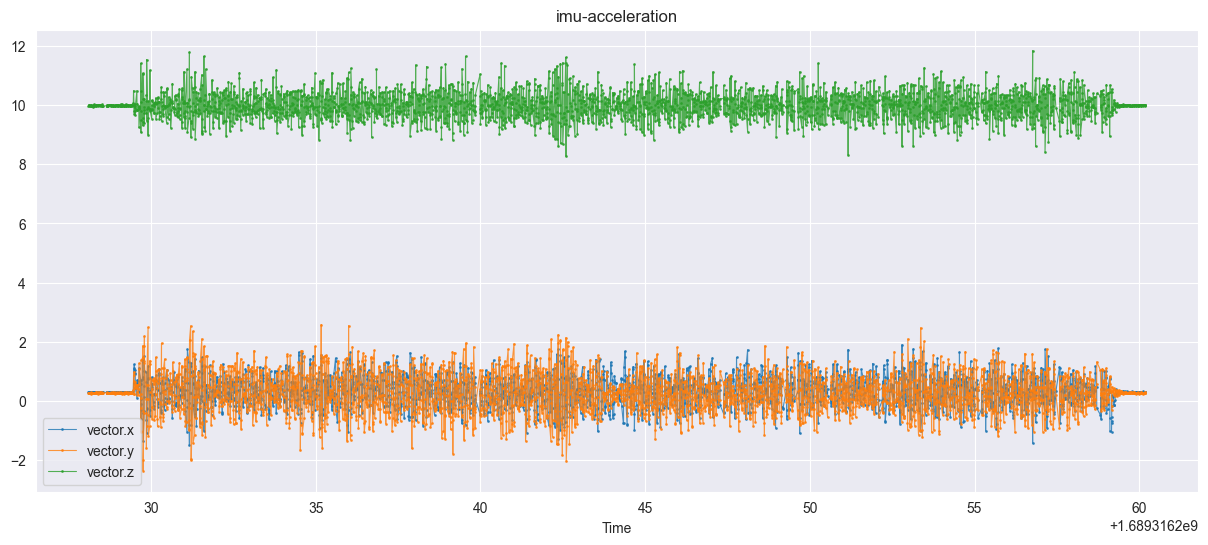

In [245]:
key = 'imu-acceleration'
imu_acceleration = topic_data[key]
cols = ['vector.x', 'vector.y', 'vector.z']
plot_signal(imu_acceleration, cols, key)

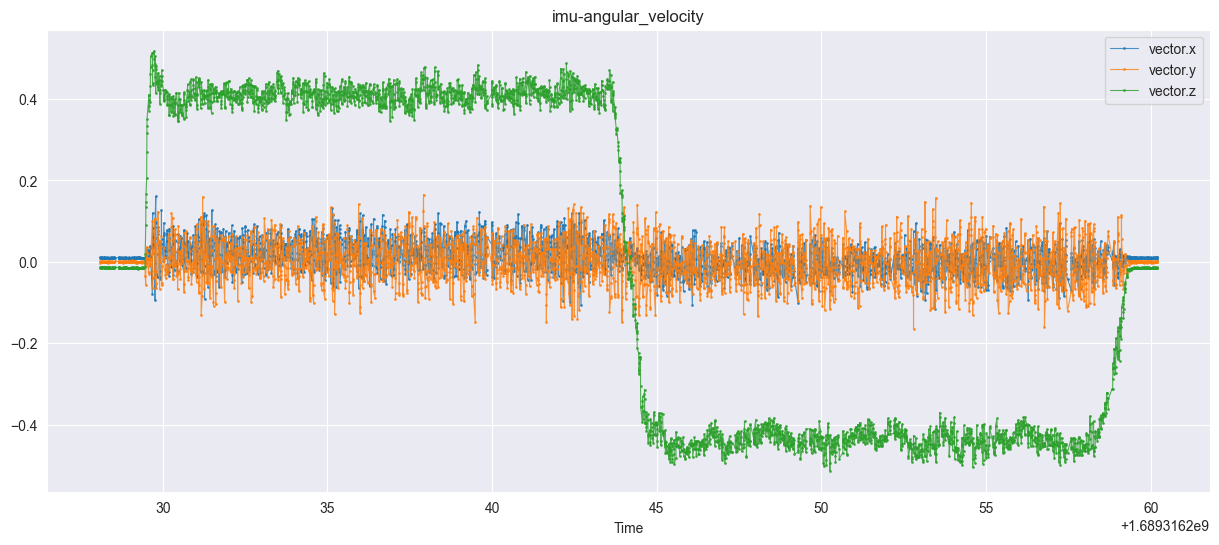

In [246]:
key = 'imu-angular_velocity'
imu_angular_velocity = topic_data[key]
cols = ['vector.x', 'vector.y', 'vector.z']
plot_signal(imu_angular_velocity, cols, key)

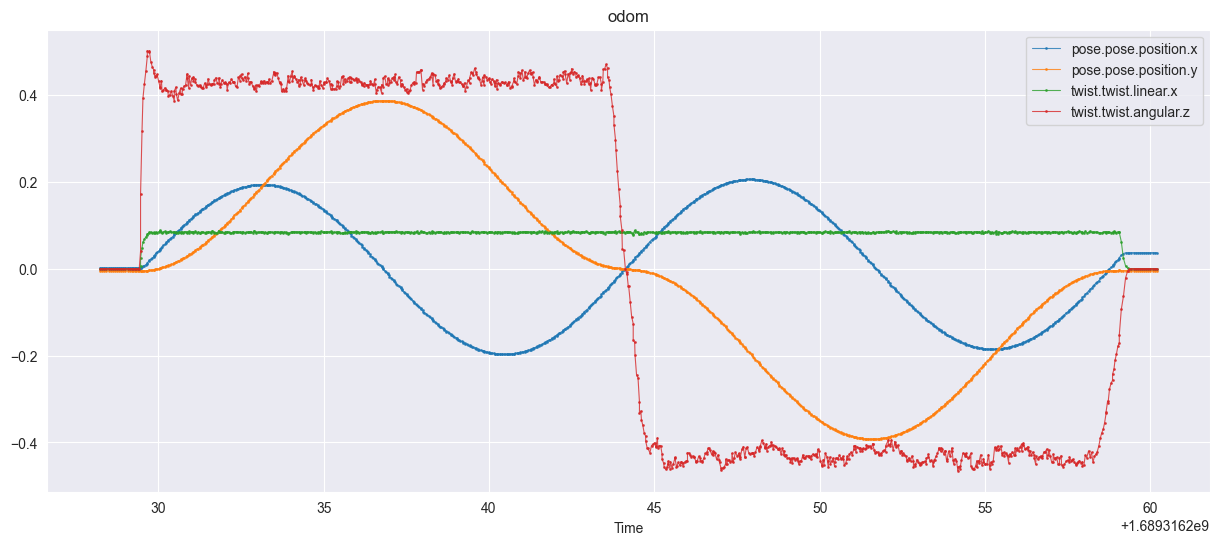

In [247]:
key = 'odom'
odom = topic_data[key]
cols = ['pose.pose.position.x', 'pose.pose.position.y', 'twist.twist.linear.x', 'twist.twist.angular.z']
plot_signal(odom, cols, key)

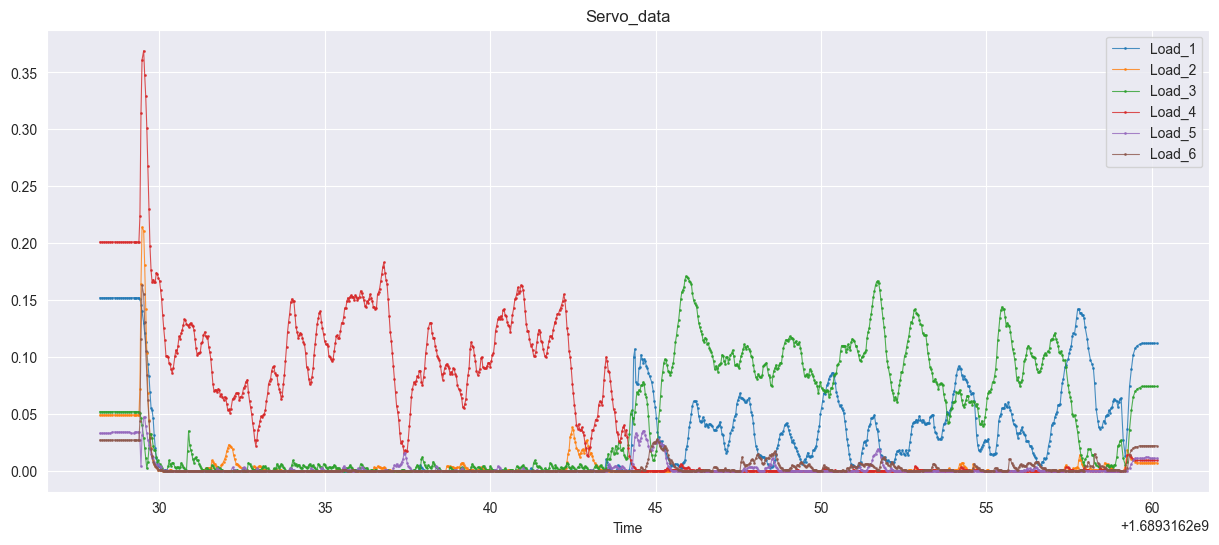

In [248]:
key = 'Servo_data'
servo_data = topic_data[key]
servo_data.rename(columns={"values": "load"}, inplace=True)
servo_data = unpack_servo_data(servo_data)
cols = servo_data.columns[1:]
plot_signal(servo_data, cols, key)

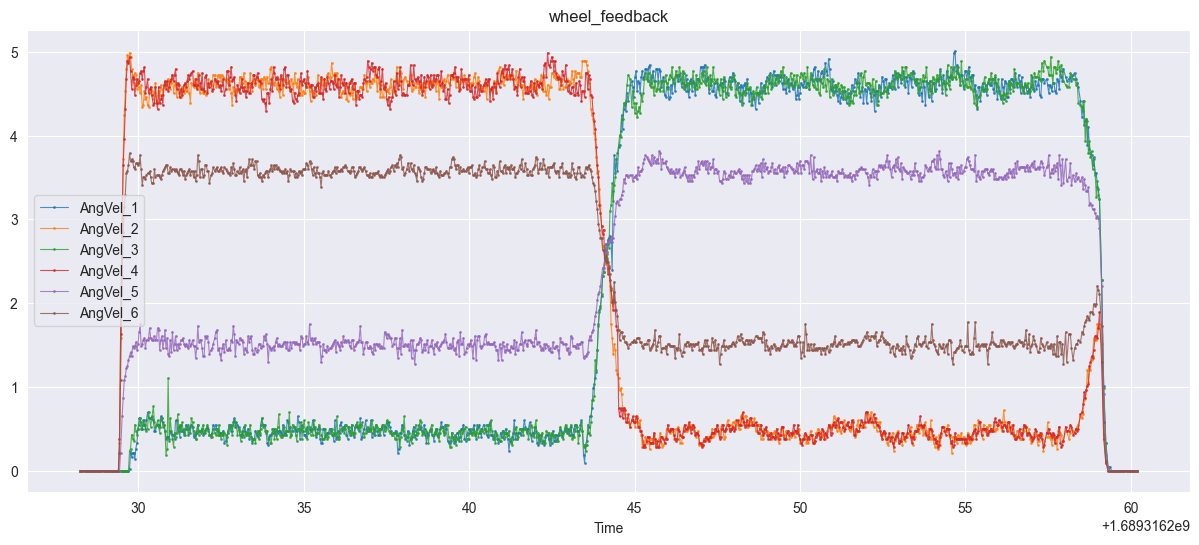

In [249]:
key = 'wheel_feedback'
wheel_feedback = topic_data[key]
wheel_feedback.rename(columns={"values": "angular_velocity"}, inplace=True)
wheel_feedback = unpack_ang_vel_data(wheel_feedback)
cols = wheel_feedback.columns[1:]
plot_signal(wheel_feedback, cols, key)

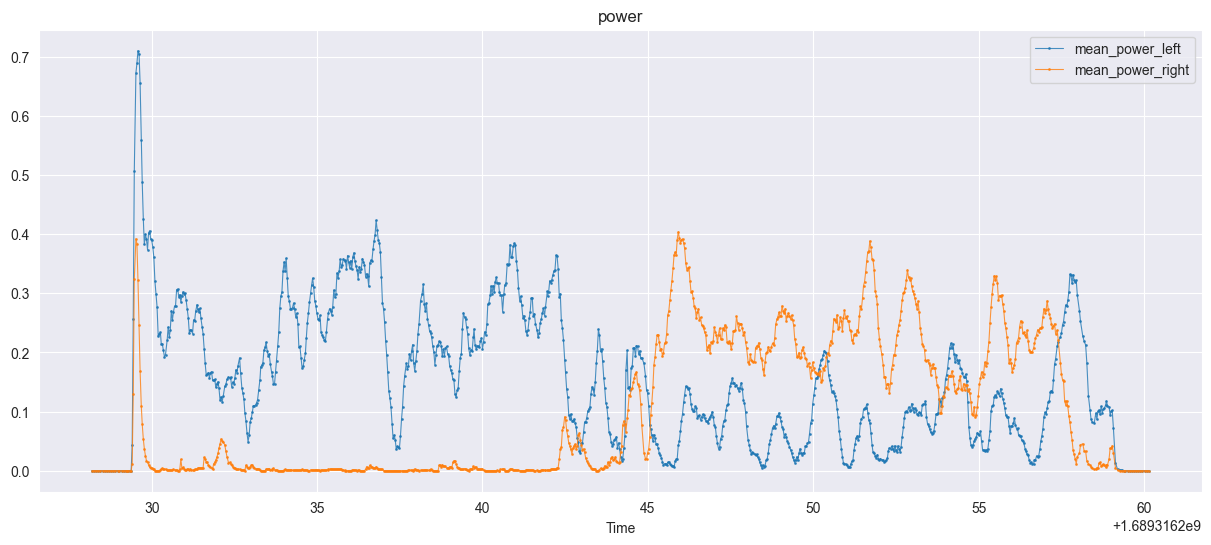

In [250]:
power = calculate_mean_power(servo_data.drop(columns=['Time']), wheel_feedback.drop(columns=['Time']), OLD)
power = pd.concat([servo_data['Time'], power], axis=1)
cols = power.columns[-2:]
plot_signal(power, cols, 'power')

### Refine data

In [251]:
imu_data = topic_data['imu-data']

In [266]:
if '4W' in bag_dir:
    cmd_vel_refined = cmd_vel[['Time', 'linear.x', 'angular.z']]
else:
    cmd_vel_refined = cmd_vel[['Time', 'twist.linear.x', 'twist.angular.z']]
imu_acceleration_refined = imu_data[['Time', 'linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z']]
imu_angular_velocity_refined = imu_data[['Time', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z']]
odom_refined = odom[['Time', 'pose.pose.position.x', 'pose.pose.position.y', 'twist.twist.linear.x', 'twist.twist.angular.z']]
power_refined = power[['Time', 'mean_power_left', 'mean_power_right']]

In [273]:
dataframes = [cmd_vel_refined, imu_acceleration_refined, imu_angular_velocity_refined, odom_refined, power_refined]
dataframe = ft.reduce(lambda left, right: pd.merge(left, right, how='outer', on='Time'), dataframes)
dataframe.ffill(inplace=True)
dataframe.bfill(inplace=True)
dataframe['Time'] -= dataframe['Time'].min()
dataframe

,Time,twist.linear.x,twist.angular.z,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,angular_velocity.x,angular_velocity.y,angular_velocity.z,pose.pose.position.x,pose.pose.position.y,twist.twist.linear.x,twist.twist.angular.z,mean_power_left,mean_power_right
0,0.000000,0.0,0.0,0.307692,0.283983,9.961403,0.011105,-0.001640,-0.013237,0.00220,-0.004929,0.0,0.0,0.0,0.0
1,0.002437,0.0,0.0,0.291857,0.254908,9.992146,0.009641,0.002180,-0.014029,0.00220,-0.004929,0.0,0.0,0.0,0.0
2,0.004135,0.0,0.0,0.285395,0.262298,9.994335,0.010751,0.000011,-0.014574,0.00220,-0.004929,0.0,0.0,0.0,0.0
3,0.020715,0.0,0.0,0.301243,0.280228,9.975706,0.009636,-0.001361,-0.014225,0.00220,-0.004929,0.0,0.0,0.0,0.0
4,0.022693,0.0,0.0,0.279917,0.263481,10.004834,0.010513,0.000590,-0.013337,0.00220,-0.004929,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,32.076311,0.0,0.0,0.297960,0.288235,10.010040,0.009513,0.001112,-0.014257,0.03679,-0.004329,0.0,0.0,0.0,0.0
6015,32.077367,0.0,0.0,0.290320,0.262388,10.014127,0.011573,-0.000466,-0.014271,0.03679,-0.004329,0.0,0.0,0.0,0.0
6016,32.077373,0.0,0.0,0.301004,0.301999,9.986901,0.010830,-0.000876,-0.015024,0.03679,-0.004329,0.0,0.0,0.0,0.0
6017,32.084847,0.0,0.0,0.292759,0.256802,9.988792,0.008089,0.001576,-0.013484,0.03679,-0.004329,0.0,0.0,0.0,0.0


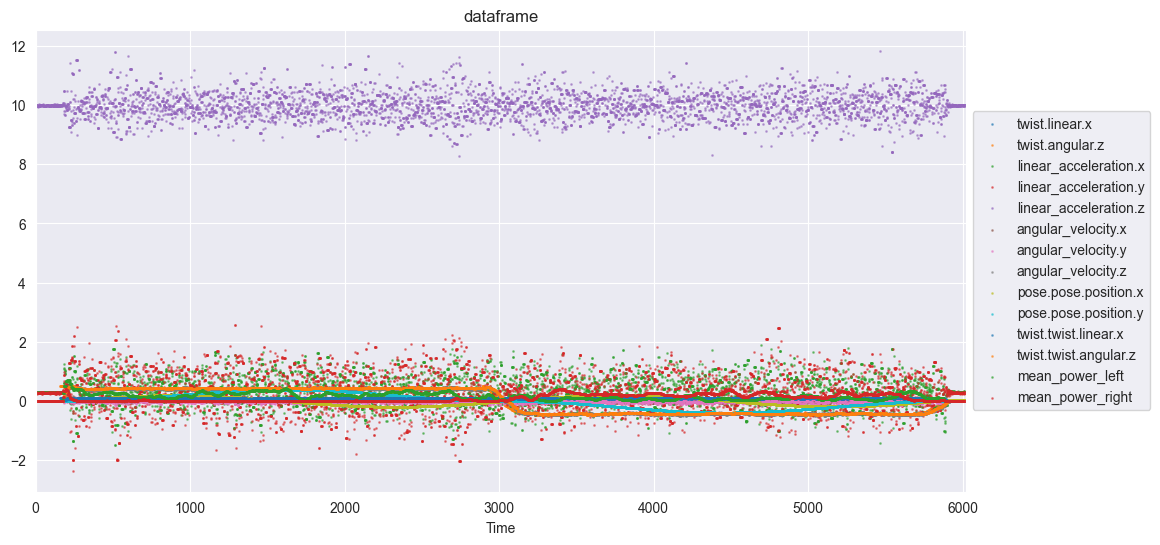

In [274]:
fig, ax = plt.subplots(figsize=(15, 6))

for column in dataframe.columns[1:]:
    ax.scatter(x=dataframe.index, y=dataframe[column], s=1, alpha=0.5, label=column)
ax.set_title('dataframe')
ax.set_xlabel('Time')
ax.set_xlim(dataframe.index[0], dataframe.index[-1])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Correlation matrix

(14.5, -0.5)

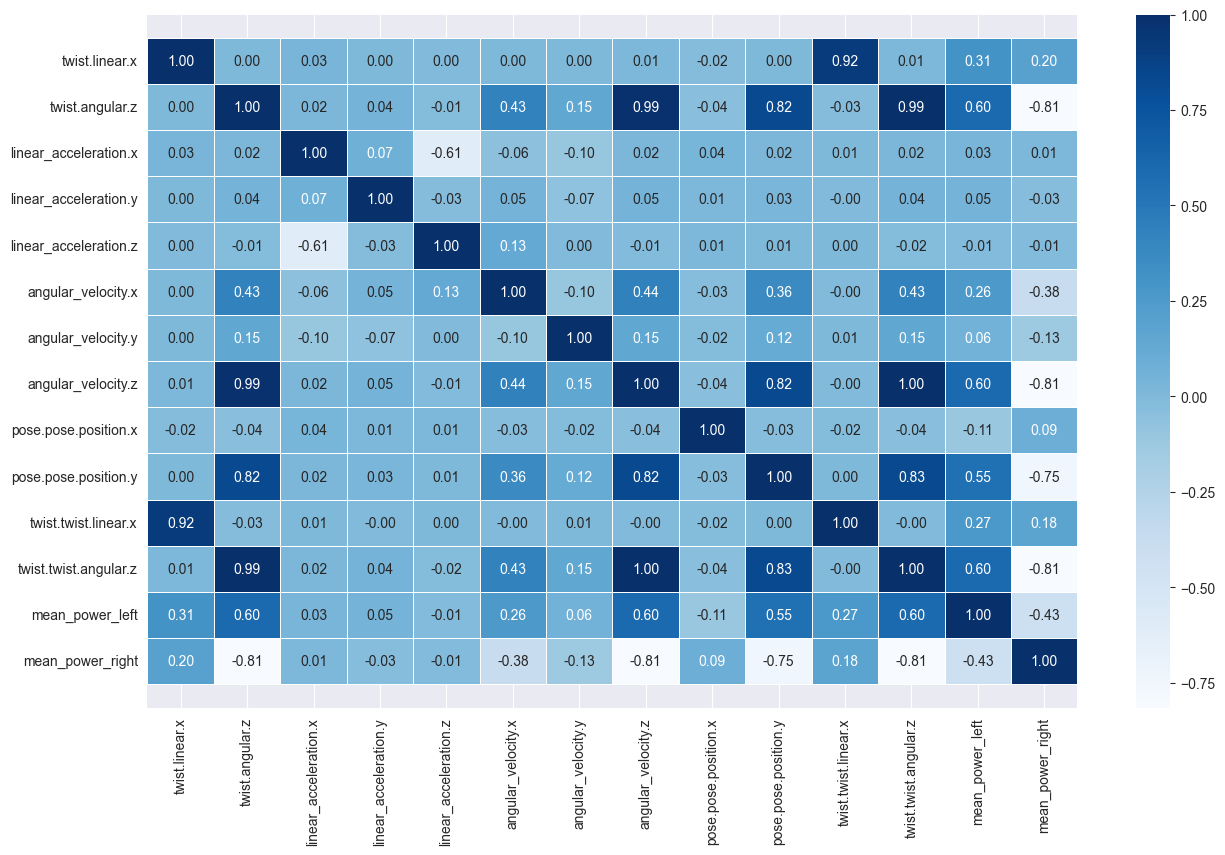

In [275]:
corr_matrix = dataframe.drop(columns=['Time']).corr()
fig, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### Correlation visualizations

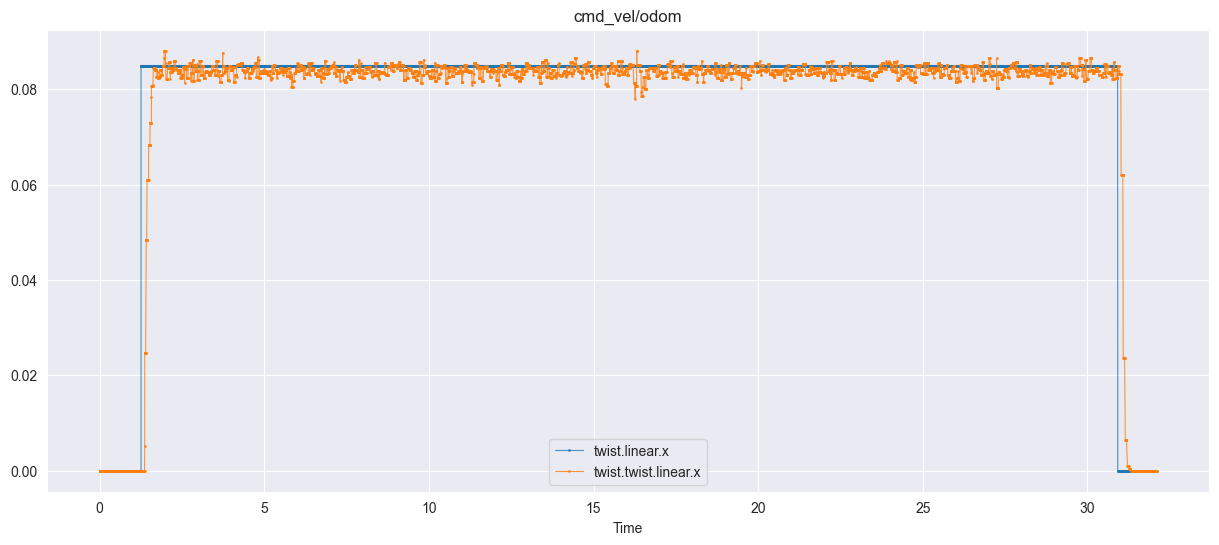

In [276]:
# cmd_vel / odom
if '4W' in bag_dir:
    cols = ['linear.x', 'twist.twist.linear.x']
else:
    cols = ['twist.linear.x', 'twist.twist.linear.x']
plot_signal(dataframe, cols, 'cmd_vel/odom')

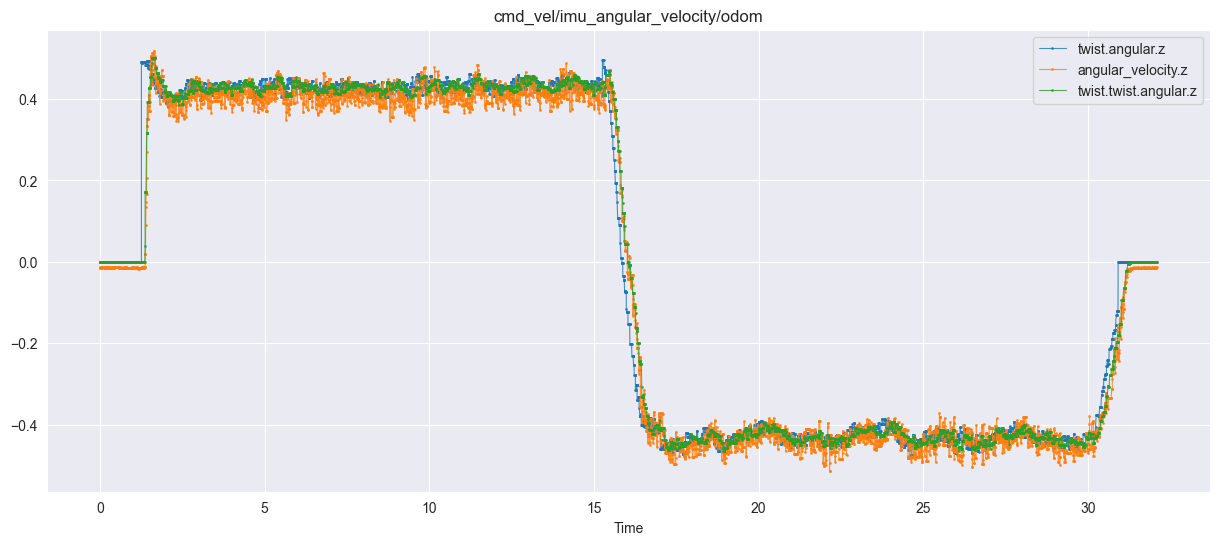

In [277]:
# cmd_vel / imu_angular_velocity / odom
if '4W' in bag_dir:
    cols = ['angular.z', 'angular_velocity.z', 'twist.twist.angular.z']
else:
    cols = ['twist.angular.z', 'angular_velocity.z', 'twist.twist.angular.z']
plot_signal(dataframe, cols, 'cmd_vel/imu_angular_velocity/odom')

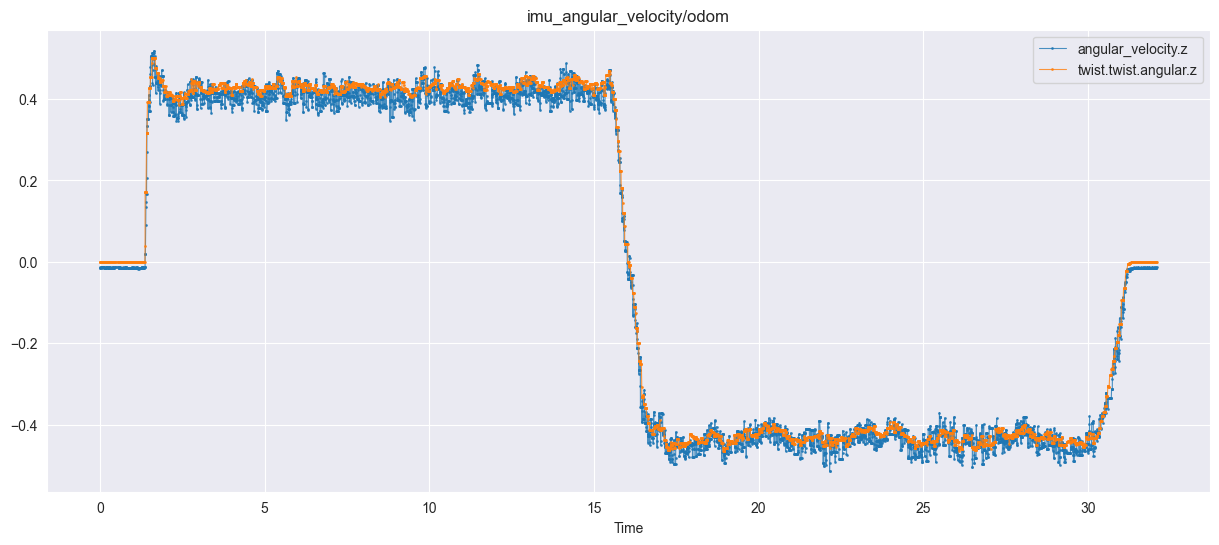

In [278]:
# imu_angular_velocity / odom
cols = ['angular_velocity.z', 'twist.twist.angular.z']
plot_signal(dataframe, cols, 'imu_angular_velocity/odom')

# Train set

In [280]:
with open('../data/train_set/labels.json') as fp:
    labels = json.load(fp)

In [289]:
dataset = [(DATA_DIR.joinpath(key + '.csv'), values['surface']) for key, values in labels.items() if values['kinematics'] in ('4W', '6W') and values['spacing'] == 'R1' and 'T1' in values['trajectory']]

In [290]:
files = pd.Series([run[0] for run in dataset], name='bag_name')
y = [run[1] for run in dataset]

In [291]:
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

In [292]:
X = [pd.read_csv(sample, index_col=[0])[[
    'Time',
    'linear_acceleration.x',
    'linear_acceleration.y',
    'linear_acceleration.z',
    'angular_velocity.x',
    'angular_velocity.y',
    'angular_velocity.z',
    'mean_power_left',
    'mean_power_right',
]] for sample in files]

for df, label in zip(X, y):
    df['target'] = label

sampling_freqs = [len(file) / file['Time'].max() for file in X]
print(np.mean(sampling_freqs))
print(np.std(sampling_freqs))

X = pd.concat(X, axis=0)

146.43119410417728
11.462349490594288


In [295]:
pd.DataFrame(mutual_info_classif(X.drop(columns=['Time', 'target']), X['target']).reshape(1, -1), columns=X.columns[1:-1], index=['Mutual Information'])

,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,angular_velocity.x,angular_velocity.y,angular_velocity.z,mean_power_left,mean_power_right
Mutual Information,0.696233,0.721823,0.713131,0.690164,0.749147,0.750043,0.956868,1.041642


(9.5, -0.5)

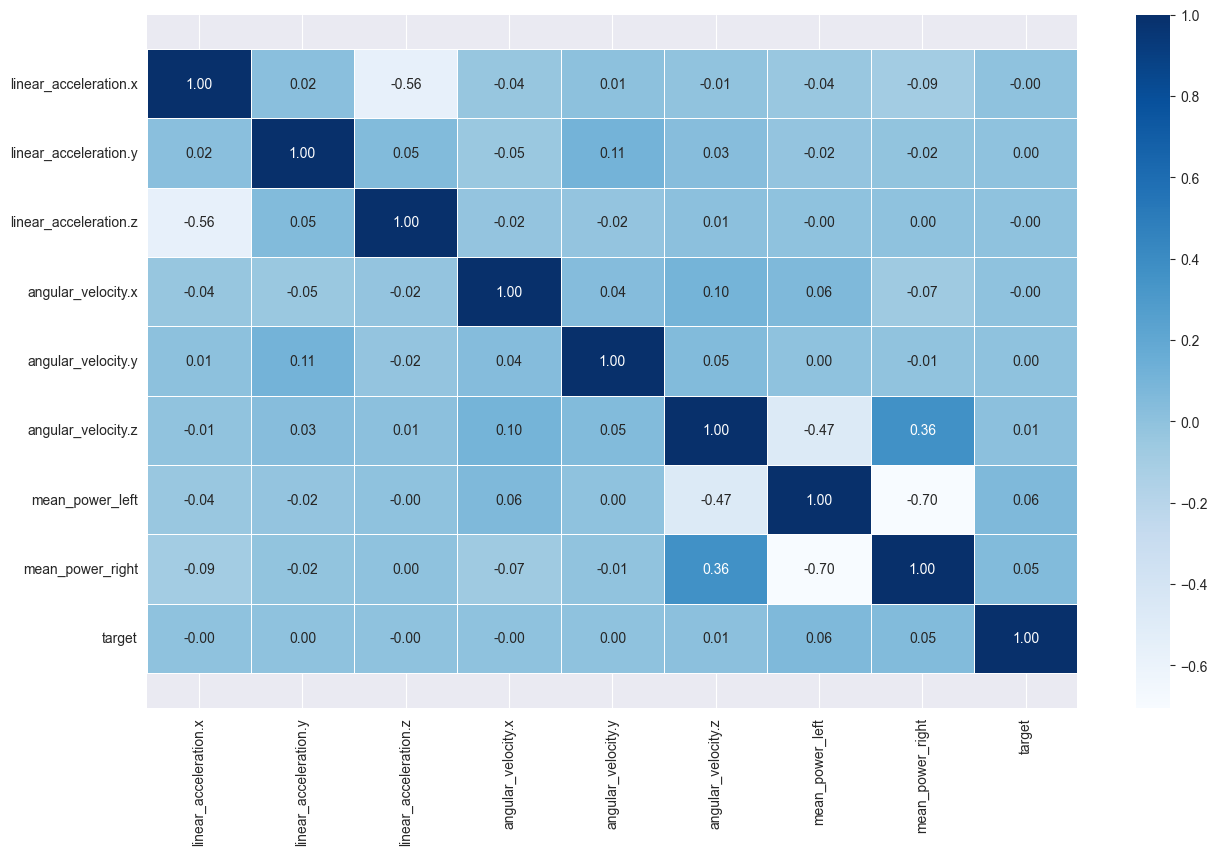

In [296]:
corr_matrix = X.drop(columns=['Time']).corr()
fig, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
sns.pairplot(X)

In [ ]:
g = sns.PairGrid(X, hue='target', diag_sharey=False, corner=True)
g.map_lower(sns.histplot)
g.map_diag(sns.histplot)
g.add_legend()

# Test set

### Directories

In [83]:
bag_dir = '../data/test_set/bags/06-05-4-kola-3-podloza'
# bag_dir = '../data/test_set/bags/06-05-4-kola-3-podloza_2'
# bag_dir = '../data/test_set/bags/06-05-4-kola-3-podloza_3'
# bag_dir = '../data/test_set/bags/07-05-4-kola-3-podloza-25-cm_CCW_1'
# bag_dir = '../data/test_set/bags/07-05-4-kola-3-podloza-25-cm_CCW_2'
# bag_dir = '../data/test_set/bags/07-05-4-kola-3-podloza-25-cm_CCW_3'
# bag_dir = '../data/test_set/bags/07-05-4-kola-3-podloza-40-cm_CCW_1'
# bag_dir = '../data/test_set/bags/07-05-4-kola-3-podloza-40-cm_CCW_2'
# bag_dir = '../data/test_set/bags/07-05-4-kola-3-podloza-40-cm_CCW_3'
# bag_dir = '../data/test_set/bags/07-05-4-kola-3-podloza-40-cm_CW_1'

OLD = False

### Load data from csv

In [84]:
bag_file_path = bag_dir + '.bag'
b = bagreader(bag_file_path)

[INFO]  Data folder ../data/test_set/bags/06-05-4-kola-3-podloza already exists. Not creating.


In [85]:
b.topic_table

,Topics,Types,Message Count,Frequency
0,/Servo_data,universal_robot_msg/Measurements,1089,15.627151
1,/cmd_vel,geometry_msgs/TwistStamped,191,19.999161
2,/imu/data,sensor_msgs/Imu,6700,3945.723424
3,/odom,nav_msgs/Odometry,1090,15.628636
4,/velocity,universal_robot_msg/VelocityWheel,191,19.998207
5,/wheel_feedback,universal_robot_msg/VelocityWheel,1090,15.627355


In [86]:
topic_data = {file[:-4]: pd.read_csv(os.path.join(bag_dir, file)) for file in os.listdir(bag_dir)}

### Topics visualization

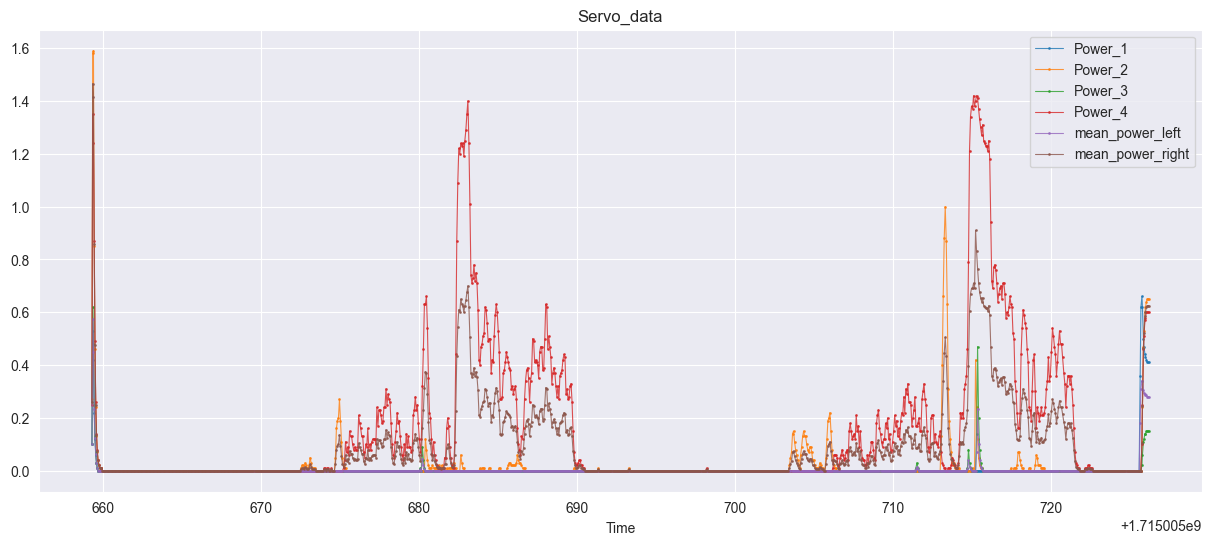

In [87]:
key = 'Servo_data'
servo_data = topic_data[key]
servo_data = unpack_servo_data(servo_data, OLD)
cols = servo_data.columns[1:].drop(['mean_power'])
plot_signal(servo_data, cols, key)

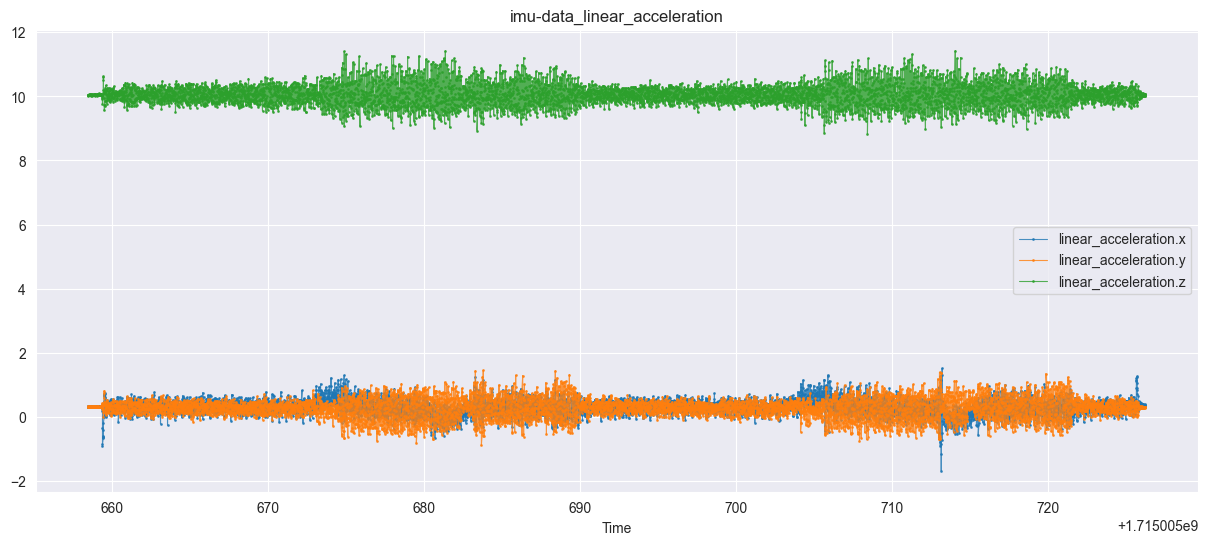

In [88]:
key = 'imu-data'
imu_data = topic_data[key]
cols = ['linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z']
plot_signal(imu_data, cols, key + '_linear_acceleration')

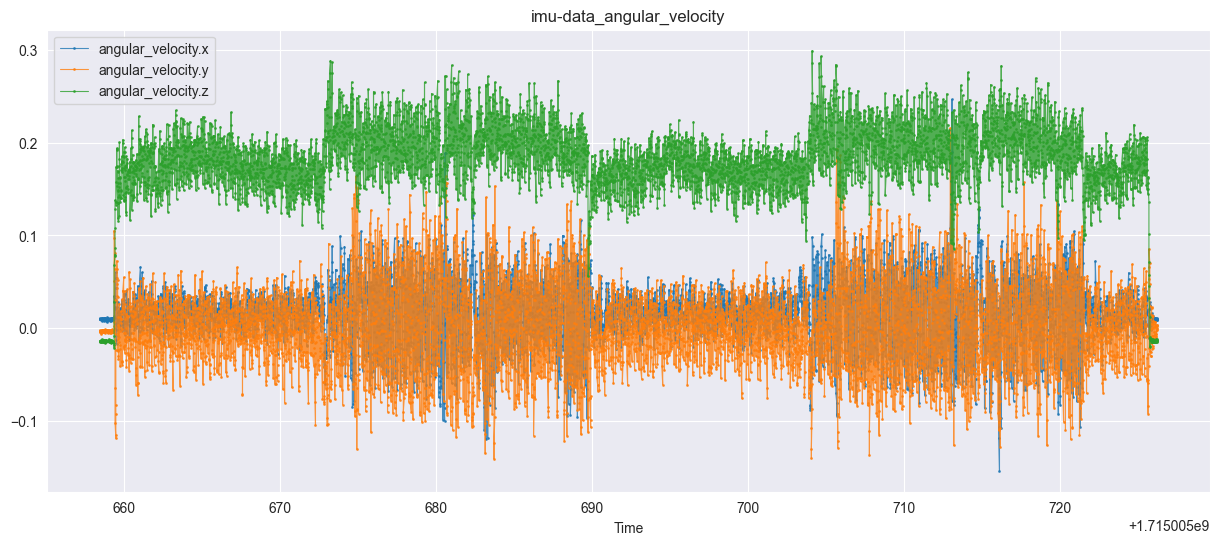

In [89]:
cols = ['angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z']
plot_signal(imu_data, cols, key + '_angular_velocity')